In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vop
import model_validation.ciff_sam_results as csr

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model3
ndbs
Fri Sep 10 15:08:07 PDT 2021


In [2]:
%load_ext autoreload
%autoreload 2

# Validation and Verification Criteria from SQLNS documentation

[SQLNS documentation on Vivarium Research](https://vivarium-research.readthedocs.io/en/latest/intervention_models/lipid_based_nutrient_supplements/index.html)

1. verification: coverage of SQ-LNS as a function of time in baseline and intervention scenario

2. verification: prevalence of stunting in supplemented vs non-supplemented group

3. verification: incidence of moderate wasting from mild in supplemented vs non-supplemented group

4. validation: check that the prevalence of moderate wasting in supplemented vs non-supplemented group agrees with the prevalence RR that we applied to the incidence instead.

5. validation: check to see how much of SAM prevalence decreases from reduction in MAM incidence from MILD.

# Load output from model 3.1 SQLNS and compute total person time

In [3]:
data = csr.VivariumResults.cleaned_from_model_spec(3.1)
data.compute_total_person_time()
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'disease_state_person_time',
 'disease_transition_count',
 'person_time']

# 1. Check SQ-LNS coverage as a function of time

Target is 90% coverage for 6 months and older, starting in 2023, 0% coverage under 6 months and in 2022.

Looks good.

In [4]:
sqlns_coverage_by_age_year = csr.get_sqlns_coverage(data, ['age', 'year'])
sqlns_coverage_baseline = sqlns_coverage_by_age_year.query("scenario=='baseline'")
sqlns_coverage_intervention = sqlns_coverage_by_age_year.query("scenario=='treatment_and_prevention'")

In [5]:
sqlns_coverage_by_age_year

,age,year,input_draw,scenario,sq_lns,value,numerator_measure,denominator_measure,multiplier
0,1-5_months,2022,29,baseline,covered,0.0,state_person_time,person_time,1
1,1-5_months,2022,29,baseline,uncovered,1.0,state_person_time,person_time,1
2,1-5_months,2022,29,treatment_and_prevention,covered,0.0,state_person_time,person_time,1
3,1-5_months,2022,29,treatment_and_prevention,uncovered,1.0,state_person_time,person_time,1
...,...,...,...,...,...,...,...,...,...
1436,late_neonatal,2026,946,baseline,covered,0.0,state_person_time,person_time,1
1437,late_neonatal,2026,946,baseline,uncovered,1.0,state_person_time,person_time,1
1438,late_neonatal,2026,946,treatment_and_prevention,covered,0.0,state_person_time,person_time,1
1439,late_neonatal,2026,946,treatment_and_prevention,uncovered,1.0,state_person_time,person_time,1


In [6]:
# Check that covered + uncovered always adds up to 1
assert np.allclose(vop.marginalize(sqlns_coverage_by_age_year, 'sq_lns').value, 1)

In [7]:
# Check that baseline coverage is 0
assert (sqlns_coverage_baseline.query("sq_lns=='covered'").value == 0).all()

## Check that coverage under 6 months is always 0

Looks good.

In [8]:
under_6mo = ['early_neonatal', 'late_neonatal', '1-5_months']
over_6mo = ['6-11_months', '12_to_23_months', '2_to_4']

In [9]:
sqlns_coverage_under_6mo = sqlns_coverage_intervention.query("age in @under_6mo and sq_lns == 'covered'")
vop.describe(vop.marginalize(sqlns_coverage_under_6mo, 'age'))

count  \
denominator_measure multiplier numerator_measure scenario                 sq_lns  year          
person_time         1          state_person_time treatment_and_prevention covered 2022   12.0   
                                                                                  2023   12.0   
                                                                                  2024   12.0   
                                                                                  2025   12.0   
                                                                                  2026   12.0   

                                                                                        mean  \
denominator_measure multiplier numerator_measure scenario                 sq_lns  year         
person_time         1          state_person_time treatment_and_prevention covered 2022   0.0   
                                                                                  2023   0.0   
                                                                                  2024   0.0   
                                                                                  2025   0.0   
                                                                                  2026   0.0   

                                                                                        std  \
denominator_measure multiplier numerator_measure scenario                 sq_lns  year        
person_time         1          state_person_time treatment_and_prevention covered 2022  0.0   
                                                                                  2023  0.0   
                                                                                  2024  0.0   
                                                                                  2025  0.0   
                                                                                  2026  0.0   

                                                                                        min  \
denominator_measure multiplier numerator_measure scenario                 sq_lns  year        
person_time         1          state_person_time treatment_and_prevention covered 2022  0.0   
                                                                                  2023  0.0   
                                                                                  2024  0.0   
                                                                                  2025  0.0   
                                                                                  2026  0.0   

                                                                                        2.5%  \
denominator_measure multiplier numerator_measure scenario                 sq_lns  year         
person_time         1          state_person_time treatment_and_prevention covered 2022   0.0   
                                                                                  2023   0.0   
                                                                                  2024   0.0   
                                                                                  2025   0.0   
                                                                                  2026   0.0   

                                                                                        50%  \
denominator_measure multiplier numerator_measure scenario                 sq_lns  year        
person_time         1          state_person_time treatment_and_prevention covered 2022  0.0   
                                                                                  2023  0.0   
                                                                                  2024  0.0   
                                                                                  2025  0.0   
                                                                                  2026  0.0   

                                                                

In [10]:
assert (sqlns_coverage_under_6mo.value == 0).all()

## Check that for age > 6mo, coverage goes from 0% in 2022 to 90% in 2023

Looks good.

In [11]:
sqlns_coverage_over_6mo = sqlns_coverage_intervention.query("age in @over_6mo and sq_lns == 'covered'")
sqlns_coverage_over_6mo

,age,year,input_draw,scenario,sq_lns,value,numerator_measure,denominator_measure,multiplier
242,12_to_23_months,2022,29,treatment_and_prevention,covered,0.000000,state_person_time,person_time,1
246,12_to_23_months,2022,223,treatment_and_prevention,covered,0.000000,state_person_time,person_time,1
250,12_to_23_months,2022,232,treatment_and_prevention,covered,0.000000,state_person_time,person_time,1
254,12_to_23_months,2022,357,treatment_and_prevention,covered,0.000000,state_person_time,person_time,1
...,...,...,...,...,...,...,...,...,...
946,6-11_months,2026,650,treatment_and_prevention,covered,0.900650,state_person_time,person_time,1
950,6-11_months,2026,680,treatment_and_prevention,covered,0.899938,state_person_time,person_time,1
954,6-11_months,2026,829,treatment_and_prevention,covered,0.900966,state_person_time,person_time,1
958,6-11_months,2026,946,treatment_and_prevention,covered,0.899846,state_person_time,person_time,1


In [12]:
age = iter(over_6mo)
vop.describe(sqlns_coverage_over_6mo.query(f"age == '{next(age)}'"))

count  \
age         denominator_measure multiplier numerator_measure scenario                 sq_lns  year          
6-11_months person_time         1          state_person_time treatment_and_prevention covered 2022   12.0   
                                                                                              2023   12.0   
                                                                                              2024   12.0   
                                                                                              2025   12.0   
                                                                                              2026   12.0   

                                                                                                        mean  \
age         denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
6-11_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                              2023  0.899874   
                                                                                              2024  0.899749   
                                                                                              2025  0.900065   
                                                                                              2026  0.900026   

                                                                                                         std  \
age         denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
6-11_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                              2023  0.000842   
                                                                                              2024  0.000631   
                                                                                              2025  0.000575   
                                                                                              2026  0.000795   

                                                                                                         min  \
age         denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
6-11_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                              2023  0.898059   
                                                                                              2024  0.898685   
                                                                                              2025  0.898633   
                                                                                              2026  0.898734   

                                                                                                        2.5%  \
age         denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
6-11_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                              2023  0.898271   
                                                                                              2024  0.898776   
                                                                                              2025  0.898903   
                                                                                              2026  0.898806   

                                                                                                         50%  \
age         denominator_measure multiplier numerator_measure scenario               

In [13]:
vop.describe(sqlns_coverage_over_6mo.query(f"age == '{next(age)}'"))

count  \
age             denominator_measure multiplier numerator_measure scenario                 sq_lns  year          
12_to_23_months person_time         1          state_person_time treatment_and_prevention covered 2022   12.0   
                                                                                                  2023   12.0   
                                                                                                  2024   12.0   
                                                                                                  2025   12.0   
                                                                                                  2026   12.0   

                                                                                                            mean  \
age             denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
12_to_23_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                                  2023  0.899852   
                                                                                                  2024  0.899821   
                                                                                                  2025  0.899815   
                                                                                                  2026  0.900073   

                                                                                                             std  \
age             denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
12_to_23_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                                  2023  0.000429   
                                                                                                  2024  0.000722   
                                                                                                  2025  0.000504   
                                                                                                  2026  0.000556   

                                                                                                             min  \
age             denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
12_to_23_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                                  2023  0.899119   
                                                                                                  2024  0.898311   
                                                                                                  2025  0.898926   
                                                                                                  2026  0.899063   

                                                                                                            2.5%  \
age             denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
12_to_23_months person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                                  2023  0.899198   
                                                                                                  2024  0.898458   
                                                                                                  2025  0.899028   
                                                                                                  2026  0.899166   

                                                            

In [14]:
vop.describe(sqlns_coverage_over_6mo.query(f"age == '{next(age)}'"))

count  \
age    denominator_measure multiplier numerator_measure scenario                 sq_lns  year          
2_to_4 person_time         1          state_person_time treatment_and_prevention covered 2022   12.0   
                                                                                         2023   12.0   
                                                                                         2024   12.0   
                                                                                         2025   12.0   
                                                                                         2026   12.0   

                                                                                                   mean  \
age    denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
2_to_4 person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                         2023  0.900106   
                                                                                         2024  0.900051   
                                                                                         2025  0.899955   
                                                                                         2026  0.899853   

                                                                                                    std  \
age    denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
2_to_4 person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                         2023  0.000567   
                                                                                         2024  0.000479   
                                                                                         2025  0.000392   
                                                                                         2026  0.000369   

                                                                                                    min  \
age    denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
2_to_4 person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                         2023  0.899034   
                                                                                         2024  0.899220   
                                                                                         2025  0.899241   
                                                                                         2026  0.899204   

                                                                                                   2.5%  \
age    denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
2_to_4 person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                                                                         2023  0.899135   
                                                                                         2024  0.899328   
                                                                                         2025  0.899335   
                                                                                         2026  0.899248   

                                                                                                    50%  \
age    denominator_measure multiplier numerator_measure scenario                 sq_lns  year             
2_to_4 person_time         1          state_person_time treatment_and_prevention covered 2022  0.000000   
                                             

# 2. Verify prevalence of stunting in supplemented vs non-supplemented group

See [SQ-LNS Vivarium Modeling Strategy](https://vivarium-research.readthedocs.io/en/latest/intervention_models/lipid_based_nutrient_supplements/index.html#vivarium-modeling-strategy)

Target prevalence ratios Pr(cat_i | SQLNS) / Pr(cat_i | no SQLNS):
- cat1 (severe stunting): 0.85 (95% CI 0.74 to 0.98)
- cat2 (moderate stunting): 0.93 (95% CI 0.88 to 0.98)
- cat3 (mild stunting): Ratio depends on the category prevalences for the stratum -- should be greater than 1
- cat4 (TMREL): 1.0 (no uncertainty)

We'll compute the prevalence ratios for each (year, sex, age, draw) combination for which both SQLNS-covered person-time and SQLNS-uncovered person-time is nonzero. There are 288 such combinations: (1 intervention scenario) x (4 years > 2022) x (2 sexes) x (3 age groups > 6mo) x (12 draws).
 
First define some functions that will be useful later.

In [15]:
def normal_dist_from_mean_lower_upper(mean, lower, upper, scale_factor=1, quantile_ranks=(0.025,0.975)):
    """Returns a frozen normal distribution with the specified mean, such that
    (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]).
    The `scale_factor` parameter allows scaling the resulting distribution by a specified factor.
    """
    # quantiles of the standard normal distribution with specified quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    scale = (upper - lower) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen normal distribution
    return stats.norm(loc=mean, scale=scale*scale_factor)

def plot_pdf(dist, label, ax=None):
    """Plot the probability density function of a scipy.stats frozen distribution."""
    if ax is None: ax = plt.gca()
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x), lw=2, alpha=0.8, label=label)

In [16]:
data.stunting_state_person_time

,sex,year,stunting_state,measure,input_draw,scenario,value,sq_lns,age
0,female,2022,cat1,state_person_time,29,baseline,0.000000,covered,early_neonatal
1,female,2022,cat1,state_person_time,29,baseline,0.000000,uncovered,early_neonatal
2,female,2022,cat1,state_person_time,29,baseline,0.000000,covered,late_neonatal
3,female,2022,cat1,state_person_time,29,baseline,0.000000,uncovered,late_neonatal
...,...,...,...,...,...,...,...,...,...
11516,male,2026,cat4,state_person_time,946,treatment_and_prevention,43671.262149,covered,12_to_23_months
11517,male,2026,cat4,state_person_time,946,treatment_and_prevention,4796.904860,uncovered,12_to_23_months
11518,male,2026,cat4,state_person_time,946,treatment_and_prevention,109126.299795,covered,2_to_4
11519,male,2026,cat4,state_person_time,946,treatment_and_prevention,11987.500342,uncovered,2_to_4


## Calculate the prevalence ratios

Should we stratify by year, or not??? Omitting year stratification decreases the variance in the computed prevalence ratios. Not sure what that means or whether it's desirable for verification purposes.

In [17]:
stunting_prevalence_ratio = csr.get_sqlns_risk_prevalence_ratio(data, 'stunting', stratify_by_year=True)
stunting_prevalence_ratio

,year,sex,age,stunting_state,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier
0,2023,female,12_to_23_months,cat1,29,treatment_and_prevention,0.840435,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
1,2023,female,12_to_23_months,cat1,223,treatment_and_prevention,0.859978,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
2,2023,female,12_to_23_months,cat1,232,treatment_and_prevention,0.844374,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
3,2023,female,12_to_23_months,cat1,357,treatment_and_prevention,0.878011,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
...,...,...,...,...,...,...,...,...,...,...
1148,2026,male,6-11_months,cat4,650,treatment_and_prevention,0.994527,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
1149,2026,male,6-11_months,cat4,680,treatment_and_prevention,0.983574,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
1150,2026,male,6-11_months,cat4,829,treatment_and_prevention,1.008697,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1
1151,2026,male,6-11_months,cat4,946,treatment_and_prevention,1.001852,stunting_prevalence_among_sqlns_covered,stunting_prevalence_among_sqlns_uncovered,1


## How much do the prevalence ratios vary across draws within each stratum?

Each row of the below table describes the distribution across draws for a single stratum.

In [18]:
# How much do the prevalence ratios vary across draws within each stratum?
# Looks like from about .80-.83 to .88-.91 from the 8 visible rows
vop.describe(stunting_prevalence_ratio.query("stunting_state=='cat1'"))

count  \
age             denominator_measure                       multiplier numerator_measure                       scenario                 sex    stunting_state year          
12_to_23_months stunting_prevalence_among_sqlns_uncovered 1          stunting_prevalence_among_sqlns_covered treatment_and_prevention female cat1           2023   12.0   
                                                                                                                                                            2024   12.0   
                                                                                                                                                            2025   12.0   
                                                                                                                                                            2026   12.0   
...                                                                                                                                                                 ...   
6-11_months     stunting_prevalence_among_sqlns_uncovered 1          stunting_prevalence_among_sqlns_covered treatment_and_prevention male   cat1           2023   12.0   
                                                                                                                                                            2024   12.0   
                                                                                                                                                            2025   12.0   
                                                                                                                                                            2026   12.0   

                                                                                                                                                                      mean  \
age             denominator_measure                       multiplier numerator_measure                       scenario                 sex    stunting_state year             
12_to_23_months stunting_prevalence_among_sqlns_uncovered 1          stunting_prevalence_among_sqlns_covered treatment_and_prevention female cat1           2023  0.862358   
                                                                                                                                                            2024  0.856474   
                                                                                                                                                            2025  0.848152   
                                                                                                                                                            2026  0.855110   
...                                                                                                                                                                    ...   
6-11_months     stunting_prevalence_among_sqlns_uncovered 1          stunting_prevalence_among_sqlns_covered treatment_and_prevention male   cat1           2023  0.847798   
                                                                                                                                                            2024  0.862814   
                                                                                                                                                            2025  0.849090   
                                                                                                                                                            2026  0.851276   

                                                                                                                                                                       std  \
age             denominator_measure                       multiplier numerator_measure                       scenario                 sex    stunting_state year             
12_to_23_months s

## How much do the prevalence ratios vary across strata within a single draw?

The variation within each draw is similar to the variation between draws shown above.

The means for each draw all look suspiciously close to 0.85. I would expect the means for the 12 draws to look like 12 values drawn from the normal distribution with mean 0.85 and central 95% interval (0.74, 0.98) -- see sample values below. Instead it seems like maybe within each draw, values are being drawn from this distribution, wihch is different from my interpretation of parameter uncertainty. Am I thinking about this the right way?

In [19]:
cat1_dist = normal_dist_from_mean_lower_upper(0.85, 0.74, 0.98)
cat1_dist.rvs(12)

array([0.79720684, 0.87724187, 0.7837265 , 0.78070813, 0.87892382,
       0.83945878, 0.906437  , 0.86465482, 0.82687448, 0.93150207,
       0.84682143, 0.79310103])

In [20]:
cat1_dist.rvs(12)

array([0.75153404, 0.84894095, 0.8865375 , 0.75254683, 0.74650949,
       0.85630741, 0.91323477, 0.91277555, 0.94138705, 0.80748848,
       0.75060315, 0.85028009])

In [21]:
# How much do the prevalence ratios vary across strata within a single draw?
# from about .80 to .89 for draw 29, similar to the variation between draws above
stunting_prevalence_ratio.query("stunting_state=='cat1' and input_draw==29").value.describe()

count    24.000000
mean      0.847264
std       0.018603
min       0.795176
25%       0.840170
50%       0.850236
75%       0.857313
max       0.892203
Name: value, dtype: float64

In [22]:
stunting_prevalence_ratio.query("stunting_state=='cat1' and input_draw==223").value.describe()

count    24.000000
mean      0.850664
std       0.019861
min       0.817167
25%       0.841831
50%       0.849781
75%       0.853955
max       0.904316
Name: value, dtype: float64

In [23]:
stunting_prevalence_ratio.query("stunting_state=='cat1' and input_draw==232").value.describe()

count    24.000000
mean      0.838565
std       0.019476
min       0.796221
25%       0.828939
50%       0.843691
75%       0.850775
max       0.868862
Name: value, dtype: float64

In [24]:
stunting_prevalence_ratio.query("stunting_state=='cat1' and input_draw==357").value.describe()

count    24.000000
mean      0.857703
std       0.018747
min       0.816619
25%       0.849407
50%       0.853134
75%       0.874370
max       0.889523
Name: value, dtype: float64

## Verify that prevalence ratios match the targets for each stunting category

Targets:
- cat1 (severe stunting): 0.85 (95% CI 0.74 to 0.98)
- cat2 (moderate stunting): 0.93 (95% CI 0.88 to 0.98)
- cat3 (mild stunting): Ratio depends on the category prevalences for the stratum -- should be greater than 1
- cat4 (TMREL): 1.0 (no uncertainty)
 
The sim means are matching the targets quite well, but there is less variation than I would expect from our specified uncertainty. This could be because we only have 12 draws, or because the ratios for different strata are not independent within the same draw, or both. Or it could be related to my comment above about the parameter uncertainty behaving differently from my expectations. Or it could be none of these. I'm not sure how to correctly stratify our resuls to verify that the uncertainty matches our specification.

In [25]:
stunting_prevalence_ratio.query("stunting_state == 'cat1'").value.describe(percentiles=[0.025,0.975])

count    288.000000
mean       0.851874
std        0.020178
min        0.773168
2.5%       0.805503
50%        0.851308
97.5%      0.890926
max        0.912309
Name: value, dtype: float64

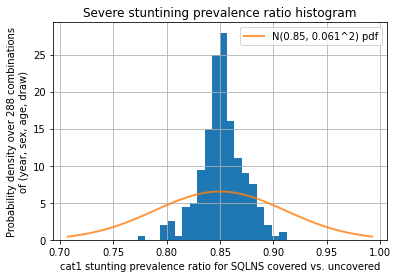

In [26]:
stunting_prevalence_ratio.query("stunting_state == 'cat1'").value.hist(bins=20, density=True)
plt.xlabel("cat1 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Severe stuntining prevalence ratio histogram")
normal_dist = normal_dist_from_mean_lower_upper(0.85, 0.74, 0.98, scale_factor=1) # 0.85 (95% CI 0.74 to 0.98)
plot_pdf(normal_dist, f'N({normal_dist.mean()}, {normal_dist.std():.2}^2) pdf')
plt.legend();

In [27]:
stunting_prevalence_ratio.query("stunting_state == 'cat2'").value.describe(percentiles=[0.025,0.975])

count    288.000000
mean       0.931274
std        0.017381
min        0.878948
2.5%       0.892815
50%        0.931400
97.5%      0.966858
max        0.990079
Name: value, dtype: float64

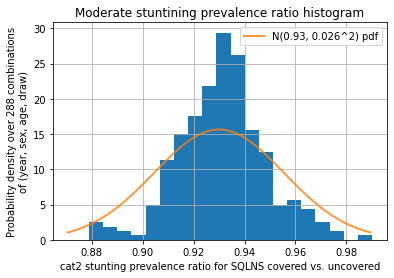

In [28]:
stunting_prevalence_ratio.query("stunting_state == 'cat2'").value.hist(bins=20, density=True)
plt.xlabel("cat2 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Moderate stuntining prevalence ratio histogram")
normal_dist = normal_dist_from_mean_lower_upper(0.93, 0.88, 0.98, scale_factor=1) # 0.93 (95% CI 0.88 to 0.98)
plot_pdf(normal_dist, f'N({normal_dist.mean()}, {normal_dist.std():.2}^2) pdf')
plt.legend()

In [29]:
stunting_prevalence_ratio.query("stunting_state == 'cat3'").value.describe(percentiles=[0.025,0.975])

count    288.000000
mean       1.170014
std        0.056519
min        1.040068
2.5%       1.068717
50%        1.184666
97.5%      1.265076
max        1.277410
Name: value, dtype: float64

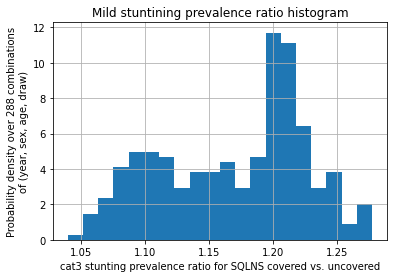

In [30]:
stunting_prevalence_ratio.query("stunting_state == 'cat3'").value.hist(bins=20, density=True)
plt.xlabel("cat3 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Mild stuntining prevalence ratio histogram");

In [31]:
stunting_prevalence_ratio.query("stunting_state == 'cat4'").value.describe(percentiles=[0.025,0.975])

count    288.000000
mean       0.998246
std        0.008142
min        0.972977
2.5%       0.982502
50%        0.998531
97.5%      1.014440
max        1.025068
Name: value, dtype: float64

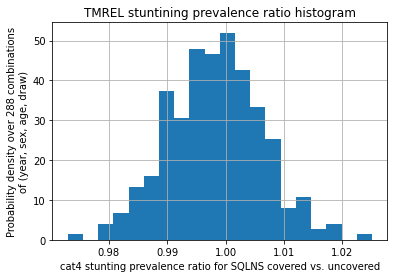

In [32]:
stunting_prevalence_ratio.query("stunting_state == 'cat4'").value.hist(bins=20, density=True)
plt.xlabel("cat4 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("TMREL stuntining prevalence ratio histogram");

# 3. Verify incidence of moderate wasting from mild in supplemented vs non-supplemented group

Not done yet.

# 4. Validation: Check that the prevalence of moderate wasting in supplemented vs non-supplemented group agrees with the prevalence RR that we applied to the incidence instead

The RR applied to the incidence rate of moderate wasting was 0.82 (95% CI 0.74 to 0.91). This was actually a prevalence ratio, so we want to see whether we get the same reduction in prevalence of moderate wasting.

## The prevalence ratio does _not_ agree with the incidence ratio

It is about 0.87 (95% UI 0.83 to 0.92), which is higher than the target 0.82.

In [33]:
data.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,sq_lns,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,410.098563,uncovered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,late_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,1218.859685,uncovered,late_neonatal
...,...,...,...,...,...,...,...,...,...
11516,male,2026,susceptible_to_child_wasting,state_person_time,946,treatment_and_prevention,63963.253936,covered,12_to_23_months
11517,male,2026,susceptible_to_child_wasting,state_person_time,946,treatment_and_prevention,7028.647502,uncovered,12_to_23_months
11518,male,2026,susceptible_to_child_wasting,state_person_time,946,treatment_and_prevention,196766.643395,covered,2_to_4
11519,male,2026,susceptible_to_child_wasting,state_person_time,946,treatment_and_prevention,21446.917180,uncovered,2_to_4


In [34]:
wasting_prevalence_ratio = csr.get_sqlns_risk_prevalence_ratio(data, 'wasting', stratify_by_year=True)
wasting_prevalence_ratio

,year,sex,age,wasting_state,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier
0,2023,female,12_to_23_months,mild_child_wasting,29,treatment_and_prevention,1.037497,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
1,2023,female,12_to_23_months,mild_child_wasting,223,treatment_and_prevention,1.055260,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
2,2023,female,12_to_23_months,mild_child_wasting,232,treatment_and_prevention,1.077259,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
3,2023,female,12_to_23_months,mild_child_wasting,357,treatment_and_prevention,1.061631,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
...,...,...,...,...,...,...,...,...,...,...
1148,2026,male,6-11_months,susceptible_to_child_wasting,650,treatment_and_prevention,1.001800,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
1149,2026,male,6-11_months,susceptible_to_child_wasting,680,treatment_and_prevention,0.994866,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
1150,2026,male,6-11_months,susceptible_to_child_wasting,829,treatment_and_prevention,1.000033,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1
1151,2026,male,6-11_months,susceptible_to_child_wasting,946,treatment_and_prevention,1.003374,wasting_prevalence_among_sqlns_covered,wasting_prevalence_among_sqlns_uncovered,1


In [35]:
wasting_prevalence_ratio.wasting_state.unique()

array(['mild_child_wasting', 'moderate_acute_malnutrition',
       'severe_acute_malnutrition', 'susceptible_to_child_wasting'],
      dtype=object)

In [36]:
wasting_prevalence_ratio.query(
    "wasting_state == 'moderate_acute_malnutrition'").value.describe(percentiles=[.025, .975])

count    288.000000
mean       0.873794
std        0.024876
min        0.816764
2.5%       0.832422
50%        0.871739
97.5%      0.924453
max        0.939889
Name: value, dtype: float64

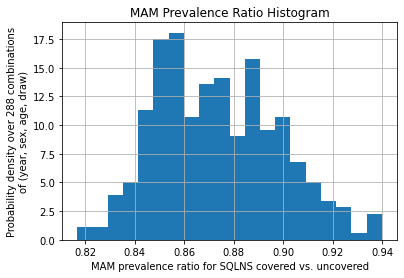

In [37]:
wasting_prevalence_ratio.query("wasting_state == 'moderate_acute_malnutrition'").value.hist(bins=20, density=True)
plt.xlabel("MAM prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("MAM Prevalence Ratio Histogram");

# 5. Validation: Check to see how much of SAM prevalence decreases from reduction in MAM incidence from MILD

Since the prevalence of MAM has increased, there will be fewer people transitioning from MAM into SAM, so the prevalence of SAM should decrase as well. But how much?

The prevalence of SAM decreases by a factor of 0.89 (95% UI 0.81 to 1.0).

In [38]:
wasting_prevalence_ratio.query(
    "wasting_state == 'severe_acute_malnutrition'").value.describe(percentiles=[.025, .975])

count    288.000000
mean       0.893418
std        0.047123
min        0.791420
2.5%       0.815943
50%        0.888211
97.5%      0.998365
max        1.038445
Name: value, dtype: float64

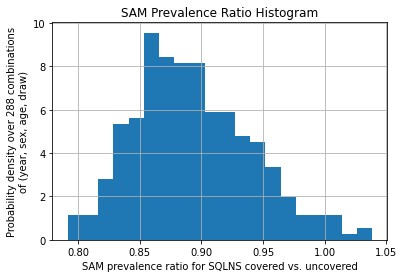

In [39]:
wasting_prevalence_ratio.query("wasting_state == 'severe_acute_malnutrition'").value.hist(bins=20, density=True)
plt.xlabel("SAM prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("SAM Prevalence Ratio Histogram");

# 6. Just for kicks, let's look at the prevalence ratios for the other two wasting categories

It looks like mild wasting prevalence increases slightly, and TMREL prevalence stays about the same.

In [40]:
wasting_prevalence_ratio.query(
    "wasting_state == 'mild_child_wasting'").value.describe(percentiles=[.025, .975])

count    288.000000
mean       1.043593
std        0.016005
min        1.007703
2.5%       1.014366
50%        1.042474
97.5%      1.079255
max        1.088407
Name: value, dtype: float64

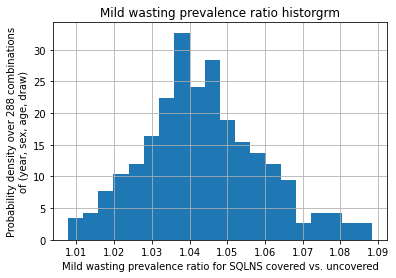

In [41]:
wasting_prevalence_ratio.query("wasting_state == 'mild_child_wasting'").value.hist(bins=20, density=True)
plt.xlabel("Mild wasting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Mild wasting prevalence ratio historgrm");

In [42]:
wasting_prevalence_ratio.query(
    "wasting_state == 'susceptible_to_child_wasting'").value.describe(percentiles=[.025, .975])

count    288.000000
mean       1.004119
std        0.006576
min        0.983561
2.5%       0.990485
50%        1.003811
97.5%      1.017270
max        1.021207
Name: value, dtype: float64

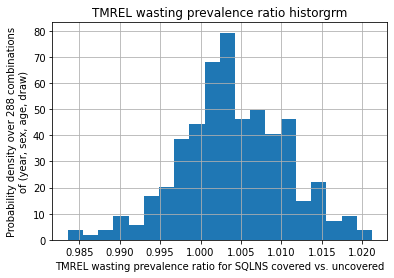

In [43]:
wasting_prevalence_ratio.query("wasting_state == 'susceptible_to_child_wasting'").value.hist(bins=20, density=True)
plt.xlabel("TMREL wasting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("TMREL wasting prevalence ratio historgrm");